In [15]:
import pandas as pd

import scipy as sc
from scipy.io import loadmat

import numpy as np

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

from matplotlib import pyplot as plt
%matplotlib inline

import time

import util
from util import *
import plot


np.random.seed(123)

In [3]:
reload(util)

<module 'util' from 'util.pyc'>

## Prepare

1. Features: 
   - kernel of all features
   - kernel of each feature
   - gaussian, polynomial
   
2. Features preprocessing:
   - normalization of the features
   - spherical normalization of kernel matrices
   
3. levels of sparsity


# Read Data

### Wpbc Data

In [36]:
reload(util)


X_wpbc, y_wpbc  = util.get_wpbc_data()
#X_wpbc, y_wpbc = wpbc_data[:,:-1], wpbc_data[:,-1]
X_wpbc = util.preprocess_feats(X_wpbc)


N = 135 #int(X_wpbc.shape[0]*.75)

K_wpbc = util.get_kernels(X_wpbc, poly=True, feat_kernel=True, gauss=True, max_gauss_width=3, min_gauss_width=-1)
#K_wpbc = util.get_kernels(X_wpbc, poly=True, feat_kernel=False, gauss=False)

K_wpbc = util.preprocess_kernel(K_wpbc)
K, K_test = K_wpbc[:,:N,:N],K_wpbc[:,N:,:N]
y, y_test = y_wpbc[:N], y_wpbc[N:]

In [4]:
P = K.shape[0]

print 'Kernels:', P

Kernels: 112


## Plot Data

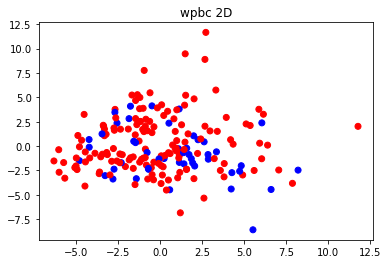

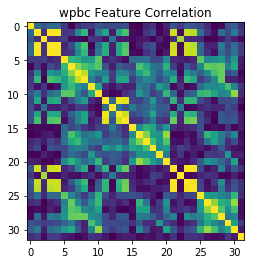

In [28]:
reload(plot)
plot.plot_data(X_wpbc,y_wpbc, 'wpbc')


## Plot Kernels

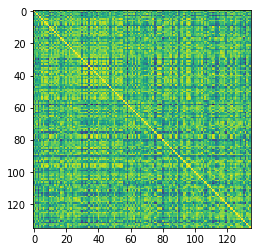

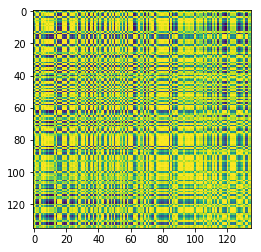

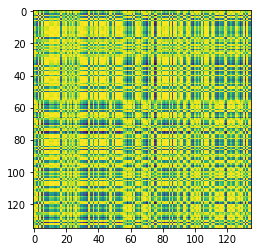

In [30]:
for i in range(3):
    plot.plot_kernel(K[i,...],'wpbc_k%d'%i)

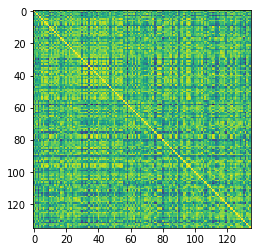

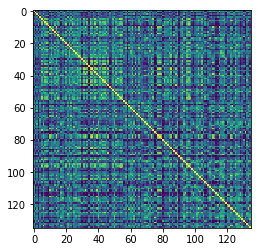

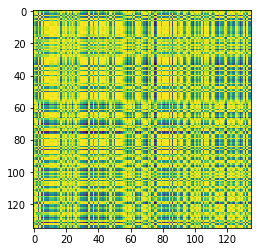

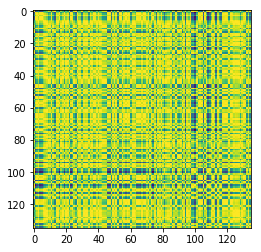

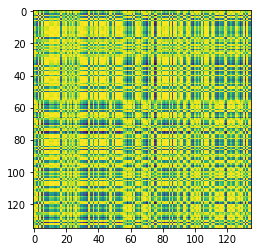

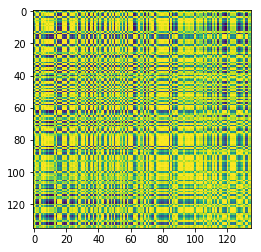

In [39]:
for i in range(2):
    plot.plot_kernel(K[i,...],'wpbc_k%d'%i)
    
for i in range(11,7,-1):
    plot.plot_kernel(K[i,...],'wpbc_k%d'%i)

In [35]:
K[4,...]

array([[1.00000000e+00, 6.36062197e-58, 4.44582258e-23, ...,
        3.18659970e-10, 5.75930590e-11, 4.63433759e-18],
       [6.36062197e-58, 1.00000000e+00, 4.05801949e-31, ...,
        1.12796359e-50, 2.99363572e-50, 1.28805612e-33],
       [4.44582258e-23, 4.05801949e-31, 1.00000000e+00, ...,
        5.62224261e-28, 7.16219711e-13, 4.48945561e-17],
       ...,
       [3.18659970e-10, 1.12796359e-50, 5.62224261e-28, ...,
        1.00000000e+00, 6.71815358e-16, 1.00180141e-17],
       [5.75930590e-11, 2.99363572e-50, 7.16219711e-13, ...,
        6.71815358e-16, 1.00000000e+00, 2.02225727e-16],
       [4.63433759e-18, 1.28805612e-33, 4.48945561e-17, ...,
        1.00180141e-17, 2.02225727e-16, 1.00000000e+00]])

# BEMKL

- Sparsity: #chosen kernels
- Running time: 
- Accuracy:

# Non-Sparse

### One time Evaluation 

In [69]:
import bemkl_binary

nsp_clf = bemkl_binary.BEMKL(sparse=False)

t1 = time.time()

nsp_clf.bemkl_binary(K,y)

t2 = time.time()
diff = t2 - t1

pred, prob = nsp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.8285714285714286
Training Time: 16.1947088242


### Cross Validation

In [27]:
reload(bemkl_binary)

cv_folds = 5
t1 = time.time()

nsp_clf = bemkl_binary.BEMKL(sparse=False)
nsp_clf.evaluate_model(K_wpbc,y_wpbc)

t2 = time.time()
diff = t2 - t1

print 'Mean training time:', diff/cv_folds
print 'Total training time:', diff

Mean Accuracy: 0.775
Mean Training Time: 116.44348607063293
Mean training time: 119.532286215
Total training time: 597.661431074


In [7]:
'''k_acc = np.empty(K.shape[0])

for kidx in range(1,K.shape[0],5):
    clf = bemkl_binary.BEMKL(sparse=sparse)

    clf.bemkl_binary(K[:kidx,...],y)

    pred, prob = clf.predict(K_test[:kidx,...])

    print 'Accuracy:'
    k_acc[kidx] = (pred==y_test).sum()*1./y_test.shape[0]
    print k_acc[kidx]'''

Accuracy:
0.8071428571428572


## Sparse

In [71]:
sp_clf = bemkl_binary.BEMKL(sparse=True)

t1 = time.time()

sp_clf.bemkl_binary(K,y)


t2 = time.time()
diff = t2 - t1

pred, prob = sp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.8047619047619048
Training Time: 16.4168908596


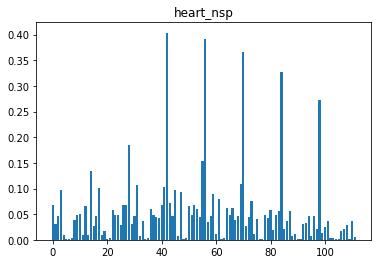

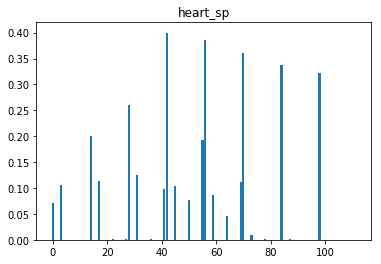

In [73]:
plot.plot_results(nsp_clf, 'wpbc')
plot.plot_results(sp_clf, 'wpbc')

In [78]:
weight_threshold = 1e-3

print 'Nmber of Chosen Kernels:'
print (sp_clf.mu_b_e > weight_threshold).sum()

Nmber of Chosen Kernels:
22


In [ ]:
'''reload(bemkl_binary)

cv_folds = 5
t1 = time.time()

clf = bemkl_binary.BEMKL(sparse=True)
clf.evaluate_model(K_wpbc,y_wpbc)

t2 = time.time()
diff = t2 - t1

print 'Mean training time:', diff/cv_folds
print 'Total training time:', diff'''

In [ ]:
plt.bar(np.arange(K.shape[0]), np.diag(cov_b_e_nsp)[1:])

In [ ]:
fig, ax = plt.subplots(1,1)

ax.set_ylim(0,.01)
plt.bar(np.arange(K.shape[0]-1), mu_b_e_sp[1:], figure=fig)
ax.bar(np.arange(K.shape[0]-1), np.diag(cov_b_e_sp)[1:],  color='r')

plt.show()
#fig.savefig('wpbc_sp_k.png', dpi=400, transparent=True, bbox_inches='tight')




In [91]:
map(lambda x: 2.**x, np.arange(-3,7))

[0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]

In [15]:
K.shape

(112, 500, 500)

In [44]:
idx = np.arange(0,300,5)
print idx.shape

a = np.copy(K[:,idx][:,:,idx])
%timeit np.dot(a,a.T)

(60,)
1 loop, best of 3: 3.09 s per loop


In [45]:
a = np.copy(K[:,:60][...,:60])
%timeit np.dot(a,a.T)

1 loop, best of 3: 5.13 s per loop
